<a href="https://colab.research.google.com/github/deepakri201/NLSTNatureSciData/blob/main/UsageNotes/NLSTSybilFMDemo/part3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NLST_Sybil_FM_demo_part3

In this notebook, we save out the features from MedSIGLip:
- medsiglip_features.csv file - the features extracted using the MedSIGLIP FM

Deepa Krishnaswamy

Brigham and Women's Hospital

July 2025

To do:
- insert instructions for HF_TOKEN

Notes:
- Colab Pro - L4 - taking about 20 minutes.

# Parameterization

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# # Copy the nlst_sybil_fm.csv from Google Drive to here
# !cp "/content/gdrive/MyDrive/Colab Notebooks/SR_NLST_Sybil/demo/nlst_sybil_fm.csv" "/content/"

In [ ]:
!wget https://github.com/deepakri201/SR_for_NLST_Sybil/releases/download/v1.0.1/nlst_sybil_fm.csv

--2025-08-29 20:30:41--  https://github.com/deepakri201/SR_for_NLST_Sybil/releases/download/v1.0.1/nlst_sybil_fm.csv
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://release-assets.githubusercontent.com/github-production-release-asset/983681157/2f516406-d8ef-45af-bd3c-d1c1379018c8?sp=r&sv=2018-11-09&sr=b&spr=https&se=2025-08-29T21%3A27%3A25Z&rscd=attachment%3B+filename%3Dnlst_sybil_fm.csv&rsct=application%2Foctet-stream&skoid=96c2d410-5711-43a1-aedd-ab1947aa7ab0&sktid=398a6654-997b-47e9-b12b-9515b896b4de&skt=2025-08-29T20%3A26%3A28Z&ske=2025-08-29T21%3A27%3A25Z&sks=b&skv=2018-11-09&sig=XI2tTWlVAmvuQBUoloMAjviWGGx8M1e00ZEOL9Ww3d4%3D&jwt=eyJ0eXAiOiJKV1QiLCJhbGciOiJIUzI1NiJ9.eyJpc3MiOiJnaXRodWIuY29tIiwiYXVkIjoicmVsZWFzZS1hc3NldHMuZ2l0aHVidXNlcmNvbnRlbnQuY29tIiwia2V5Ijoia2V5MSIsImV4cCI6MTc1NjQ5OTc0MSwibmJmIjoxNzU2NDk5NDQxLCJwYXRoIjoicmVsZWFzZWFzc2V0cHJv

In [ ]:
#@title Enter your Project ID here
# initialize this variable with your Google Cloud Project ID!
project_name = "idc-external-018" #@param {type:"string"}

import os
os.environ["GCP_PROJECT_ID"] = project_name

!gcloud config set project $project_name

from google.colab import auth
auth.authenticate_user()

Updated property [core/project].


# Environment setup for MedSIGLip

In [ ]:
# @title ## Authenticate with HuggingFace, skip if you have a HF_TOKEN secret

# Authenticate user for HuggingFace if needed. Enter token below if requested.
from huggingface_hub.utils import HfFolder

if HfFolder.get_token() is None:
    from huggingface_hub import notebook_login
    notebook_login()

In [ ]:
import os
import sys
import pandas as pd
import numpy as np

In [ ]:
!pip install idc-index

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.6/80.6 MB 21.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.2/20.2 MB 63.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 96.7 MB/s eta 0:00:00
  Attempting uninstall: duckdb
    Found existing installation: duckdb 1.3.2
    Uninstalling duckdb-1.3.2:
      Successfully uninstalled duckdb-1.3.2


In [ ]:
from idc_index import IDCClient

idc_client = IDCClient.client()

In [ ]:
from google.cloud import bigquery
from google.cloud import storage

In [ ]:
!pip install pydicom

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 41.8 MB/s eta 0:00:00


In [ ]:
import pydicom
from PIL import Image
from tensorflow.image import resize as tf_resize
import tensorflow as tf
from transformers import AutoProcessor, SiglipVisionModel, AutoModel
import torch
import matplotlib.pyplot as plt

# Download DICOM data

In [ ]:
# !cp "/content/gdrive/MyDrive/Colab Notebooks/SR_NLST_Sybil/demo/nlst_sybil_fm.csv" "/content/"

In [ ]:
df_sr_and_nlst = pd.read_csv("/content/nlst_sybil_fm.csv")

In [ ]:
# Specify classes to use for the classification
# Keep two stages for classification
print(len(list(set(df_sr_and_nlst[df_sr_and_nlst['de_stag_mapped']==0]['PatientID'].values))))
print(len(list(set(df_sr_and_nlst[df_sr_and_nlst['de_stag_mapped']==1]['PatientID'].values))))

df_sr_and_nlst_subset = df_sr_and_nlst[df_sr_and_nlst['de_stag_mapped'].isin([0,1])]

263
61


In [ ]:
SeriesInstanceUIDs_temp = sorted(list(set(df_sr_and_nlst_subset['ReferencedSeriesInstanceUID'].values)))
df_sr_and_nlst_subset = df_sr_and_nlst_subset[df_sr_and_nlst_subset['ReferencedSeriesInstanceUID'].isin(SeriesInstanceUIDs_temp)]

# We need to remove the places where the SOPInstanceUID appears twice - means >1 lesion on a slice - just to keep it simple for now.
df_sr_and_nlst_subset = df_sr_and_nlst_subset[df_sr_and_nlst_subset['ReferencedSOPInstanceUID'].duplicated(keep=False) == False]
print('num_sop: ' + str(len(df_sr_and_nlst_subset)))

num_series = len(SeriesInstanceUIDs_temp)
print('num_series: ' + str(num_series))

# It's fine that the num_sop>num_series. Some series have multiple SOPInstanceUIDs, so there are lesions on multiple slices.

num_sop: 525
num_series: 465


In [ ]:
# Since we just need the slice the lesion is on - use gsutil for now to copy specific instances.

dicom_directory = "/content/dicom"
if not os.path.isdir(dicom_directory):
  os.mkdir(dicom_directory)

# First use bigquery to get the gcs_url
SOPInstanceUID_list = list(df_sr_and_nlst_subset['ReferencedSOPInstanceUID'].values)
client_bq = bigquery.Client(project=project_name)

query = f"""
    SELECT
      SOPInstanceUID,
      gcs_url
    FROM
      `bigquery-public-data.idc_current.dicom_all`
    WHERE
      SOPInstanceUID IN UNNEST(@SOPInstanceUID_list)
      """

job_config = bigquery.QueryJobConfig(query_parameters=[bigquery.ArrayQueryParameter("SOPInstanceUID_list", "STRING", SOPInstanceUID_list)])
df_idc = client_bq.query(query, job_config=job_config).to_dataframe()

In [ ]:
print(len(SOPInstanceUID_list))
print(len(df_idc))

525
525


In [ ]:
# Copy files

gcs_url_list = df_idc['gcs_url'].values
SOPInstanceUID_list = df_idc['SOPInstanceUID'].values

# Write out gcs_urls to text file
gcs_url_list_filename = "/content/gcs_urls.txt"
with open(gcs_url_list_filename, 'w') as f:
  for gcs_url in gcs_url_list:
    f.write(gcs_url + '\n')

# Then copy
!gsutil -m cp -I < $gcs_url_list_filename $dicom_directory

# # Then download using gsutil
# num_files = len(gcs_url_list)
# checkpoints = {int((num_files) * i / 10) for i in range(1, 11)}
# dicom_filenames = []
# index = 0
# for gcs_url, SOPInstanceUID in zip(gcs_url_list, SOPInstanceUID_list):
#   input_filename = gcs_url
#   output_filename = os.path.join(dicom_directory, SOPInstanceUID + ".dcm")
#   !gsutil -m cp -r $input_filename $output_filename
#   dicom_filenames.append(output_filename)
#   if index in checkpoints:
#     print(f"{(index / num_files) * 100:.0f}% of DICOM files processed.")
#   index += 1


Copying gs://idc-open-data/031a3b86-d9e2-4ec9-81fd-f9de136a639b/b34f9da4-3126-4c82-8881-52725acb76c5.dcm...
Copying gs://idc-open-data/c37f47a5-abdf-4c1a-819f-7d1d9be6d362/259dfa12-0e8a-4fe6-9469-da6900e26325.dcm...
Copying gs://idc-open-data/dc48ee2c-c71c-4a5e-ab4b-179fd8b3aebd/6f19c661-742e-4b35-bbae-6cd21b614032.dcm...
Copying gs://idc-open-data/58085751-fd4b-4021-a4e0-6db55fdb5822/cd96fd66-a7e1-4b5f-9b3d-13b69fd03d15.dcm...
Copying gs://idc-open-data/154e7a41-13f8-400e-ba00-5d2f1ae01749/782ec887-56ba-4ebc-ae2d-e964d9b1bbc4.dcm...
Copying gs://idc-open-data/7e78d53f-17ba-460a-b2be-e07edd3ef056/c442077b-1dd9-4630-9844-c562f368ce0c.dcm...
Copying gs://idc-open-data/96ab0d8c-b2b3-4a7b-8efe-753b95258b2d/b9372ca0-4a7e-4627-b29a-4ed94b5de08b.dcm...
Copying gs://idc-open-data/ce17b228-3f1b-434e-9921-f5b960a8a090/17ca5308-ad9e-49bb-a500-4352c92765bf.dcm...
Copying gs://idc-open-data/7209e36f-2b5a-473e-b3e2-1fd6f5724d07/eaac3101-fcfa-4ff4-8d89-197ffd1111f4.dcm...
Copying gs://idc-open-data/7

In [ ]:
# Rename the files with the SOPInstanceUID instead

dicom_files = [os.path.join(dicom_directory,os.path.basename(f)) for f in gcs_url_list]

dicom_files_renamed = [os.path.join(dicom_directory,f+'.dcm') for f in SOPInstanceUID_list]
[os.rename(f,g) for f,g in zip(dicom_files, dicom_files_renamed)]

In [ ]:
# Copy DICOM files to bucket temporarily
!gsutil -m cp -r "/content/dicom" "gs://nlst_sybil_fm_demo/dicom"


Copying file:///content/dicom/1.3.6.1.4.1.14519.5.2.1.7009.9004.288104402112974102644087282432.dcm [Content-Type=application/dicom]...
Copying file:///content/dicom/1.3.6.1.4.1.14519.5.2.1.7009.9004.260215774077808411203037349671.dcm [Content-Type=application/dicom]...
Copying file:///content/dicom/1.3.6.1.4.1.14519.5.2.1.7009.9004.861902356227475174063629626919.dcm [Content-Type=application/dicom]...
Copying file:///content/dicom/1.3.6.1.4.1.14519.5.2.1.7009.9004.110957558663508404709406698147.dcm [Content-Type=application/dicom]...
Copying file:///content/dicom/1.2.840.113654.2.55.212667233448668509823774601625397015254.dcm [Content-Type=application/dicom]...
Copying file:///content/dicom/1.3.6.1.4.1.14519.5.2.1.7009.9004.524877909462145117303011770315.dcm [Content-Type=application/dicom]...
Copying file:///content/dicom/1.2.840.113654.2.55.264340670631747664693548749186374331434.dcm [Content-Type=application/dicom]...
Copying file:///content/dicom/1.3.6.1.4.1.14519.5.2.1.7009.9004.1

In [ ]:
# Download zip file
!zip -r /content/dicom.zip /content/dicom
from google.colab import files
files.download("/content/dicom.zip")

  adding: content/dicom/ (stored 0%)
  adding: content/dicom/1.3.6.1.4.1.14519.5.2.1.7009.9004.288104402112974102644087282432.dcm (deflated 41%)
  adding: content/dicom/1.3.6.1.4.1.14519.5.2.1.7009.9004.260215774077808411203037349671.dcm (deflated 48%)
  adding: content/dicom/1.3.6.1.4.1.14519.5.2.1.7009.9004.861902356227475174063629626919.dcm (deflated 50%)
  adding: content/dicom/1.3.6.1.4.1.14519.5.2.1.7009.9004.110957558663508404709406698147.dcm (deflated 56%)
  adding: content/dicom/1.2.840.113654.2.55.212667233448668509823774601625397015254.dcm (deflated 47%)
  adding: content/dicom/1.3.6.1.4.1.14519.5.2.1.7009.9004.524877909462145117303011770315.dcm (deflated 30%)
  adding: content/dicom/1.2.840.113654.2.55.264340670631747664693548749186374331434.dcm (deflated 45%)
  adding: content/dicom/1.3.6.1.4.1.14519.5.2.1.7009.9004.149554220911503047237153352362.dcm (deflated 49%)
  adding: content/dicom/1.3.6.1.4.1.14519.5.2.1.7009.9004.226079464937368046860838451926.dcm (deflated 41%)
 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Process images

In [ ]:
# First form a df_for_csv holding the information about the tumor location

df_for_csv = pd.DataFrame()
SOPInstanceUID_for_csv = list(df_sr_and_nlst_subset['ReferencedSOPInstanceUID'].values)
df_for_csv['PatientID'] = df_sr_and_nlst_subset['PatientID'].values
df_for_csv['SeriesInstanceUID'] = df_sr_and_nlst_subset['ReferencedSeriesInstanceUID'].values
df_for_csv['SOPInstanceUID'] = df_sr_and_nlst_subset['ReferencedSOPInstanceUID'].values
# df_for_csv['image_path'] = [os.path.join("/content/dicom",f+'.dcm') for f in df_for_csv['SOPInstanceUID'].values]
df_for_csv['image_path'] = [os.path.join("/content/dicom",f+".dcm") for f in SOPInstanceUID_for_csv]

center_x_voxel_list = []
center_y_voxel_list = []
height_voxel_list = []
width_voxel_list = []
min_x_voxel_list = []
max_x_voxel_list = []
min_y_voxel_list = []
max_y_voxel_list = []

dicom_files = df_for_csv['image_path'].values

# Map back to the pixel/voxel coordinates
for index, dicom_file in enumerate(dicom_files):

  center_x = df_sr_and_nlst_subset['center_x'].values[index]
  center_y = df_sr_and_nlst_subset['center_y'].values[index]
  width = df_sr_and_nlst_subset['width'].values[index]
  height = df_sr_and_nlst_subset['height'].values[index]

  min_x_voxel = center_x - width/2
  max_x_voxel = center_x + width/2
  min_y_voxel = center_y - height/2
  max_y_voxel = center_y + height/2

  center_x_voxel_list.append(np.int32(center_x))
  center_y_voxel_list.append(np.int32(center_y))
  width_voxel_list.append(np.int32(width))
  height_voxel_list.append(np.int32(height))

  min_x_voxel_list.append(np.int32(min_x_voxel))
  max_x_voxel_list.append(np.int32(max_x_voxel))
  min_y_voxel_list.append(np.int32(min_y_voxel))
  max_y_voxel_list.append(np.int32(max_y_voxel))

df_for_csv['center_x_voxel'] = center_x_voxel_list
df_for_csv['center_y_voxel'] = center_y_voxel_list
df_for_csv['height_voxel'] = height_voxel_list
df_for_csv['width_voxel'] = width_voxel_list
df_for_csv['min_x_voxel'] = min_x_voxel_list
df_for_csv['max_x_voxel'] = max_x_voxel_list
df_for_csv['min_y_voxel'] = min_y_voxel_list
df_for_csv['max_y_voxel'] = max_y_voxel_list


In [ ]:
df_for_csv.head()

,PatientID,SeriesInstanceUID,SOPInstanceUID,image_path,center_x_voxel,center_y_voxel,height_voxel,width_voxel,min_x_voxel,max_x_voxel,min_y_voxel,max_y_voxel
0,100012,1.2.840.113654.2.55.24023112856488152536348979...,1.2.840.113654.2.55.23447016361362557671014824...,/content/dicom/1.2.840.113654.2.55.23447016361...,199,310,37,41,179,220,292,329
1,100012,1.2.840.113654.2.55.50761756412482430061802871...,1.2.840.113654.2.55.23050894131215950278743827...,/content/dicom/1.2.840.113654.2.55.23050894131...,166,328,39,42,145,187,309,348
2,100147,1.2.840.113654.2.55.24785488463405747713776937...,1.2.840.113654.2.55.17981552983033538571417359...,/content/dicom/1.2.840.113654.2.55.17981552983...,150,313,37,39,131,170,295,332
3,100147,1.2.840.113654.2.55.15708941008648745210499888...,1.2.840.113654.2.55.19851369674160913596156868...,/content/dicom/1.2.840.113654.2.55.19851369674...,147,332,37,37,129,166,314,351
4,100158,1.2.840.113654.2.55.31060976780967844152296392...,1.2.840.113654.2.55.18324898484332559595555356...,/content/dicom/1.2.840.113654.2.55.18324898484...,103,272,28,27,90,117,258,286


In [ ]:
df_for_csv.sort_values(by=['width_voxel'], ascending=False).head()

,PatientID,SeriesInstanceUID,SOPInstanceUID,image_path,center_x_voxel,center_y_voxel,height_voxel,width_voxel,min_x_voxel,max_x_voxel,min_y_voxel,max_y_voxel
281,129695,1.2.840.113654.2.55.15984899811178273278176379...,1.2.840.113654.2.55.26318475184610510764140564...,/content/dicom/1.2.840.113654.2.55.26318475184...,389,339,103,123,328,451,288,391
278,129695,1.2.840.113654.2.55.74483224363270537625800138...,1.2.840.113654.2.55.11539148113020980334508333...,/content/dicom/1.2.840.113654.2.55.11539148113...,383,359,104,115,326,441,307,411
184,120289,1.2.840.113654.2.55.14313834160120760601588233...,1.2.840.113654.2.55.13407938552004689436039099...,/content/dicom/1.2.840.113654.2.55.13407938552...,135,156,90,105,83,188,111,201
311,132047,1.2.840.113654.2.55.55905915368746417680608580...,1.2.840.113654.2.55.16856261468409082575242526...,/content/dicom/1.2.840.113654.2.55.16856261468...,111,260,98,104,59,163,211,309
280,129695,1.2.840.113654.2.55.15984899811178273278176379...,1.2.840.113654.2.55.64838499121538104643406339...,/content/dicom/1.2.840.113654.2.55.64838499121...,387,340,90,103,336,439,295,385


In [ ]:
dcm = pydicom.dcmread("/content/dicom/1.2.840.113654.2.55.263184751846105107641405649093850705768.dcm")
print(dcm.ImagePositionPatient)
print(dcm.SOPInstanceUID)
print(dcm.SeriesInstanceUID)

[-128.399994, -113.400002, -218.750000]
1.2.840.113654.2.55.263184751846105107641405649093850705768
1.2.840.113654.2.55.15984899811178273278176379087873074846


In [ ]:
# Resize function

INPUT_DIMENSION = [448, 448]

def resize(image_pil):
  # Convert from PIL image to numpy
  image_np = np.array(image_pil).astype(np.float32)
  # Rescale
  image_np = (image_np-np.min(image_np)) / (np.max(image_np)-np.min(image_np))
  # Add channel dimension
  image_np = np.expand_dims(image_np, axis=-1)
  # Resize
  image_resized = tf_resize(image_np, size=INPUT_DIMENSION, method='bilinear', antialias=False)
  # Remove channel dimension
  image_resized = tf.squeeze(image_resized, axis=-1)
  # Scale
  image_resized = (image_resized.numpy() * 255).clip(0, 255).astype(np.uint8)
  # Need to have 3 channels
  image_rgb = np.stack([image_resized] * 3, axis=-1)

  return Image.fromarray(image_rgb)


# Now read in and crop the DICOM files
cropped_imgs = []
cropped_imgs_pil = []

for index, dicom_file in enumerate(dicom_files):
    dcm = pydicom.dcmread(dicom_file)
    img = dcm.pixel_array

    # crop using y for rows and x for columns (image[y1:y2, x1:x2])
    min_y_voxel = df_for_csv['min_y_voxel'].values[index]
    max_y_voxel = df_for_csv['max_y_voxel'].values[index]
    min_x_voxel = df_for_csv['min_x_voxel'].values[index]
    max_x_voxel = df_for_csv['max_x_voxel'].values[index]
    cropped_img = img[min_y_voxel:max_y_voxel, min_x_voxel:max_x_voxel]

    cropped_imgs.append(cropped_img)
    cropped_imgs_pil.append(Image.fromarray(cropped_img))

# Resize to 448x448 using TensorFlow
imgs = [resize(img) for img in cropped_imgs_pil]


# Verify images and crop by plotting

index: 281
PatientID                                                       129695
SeriesInstanceUID    1.2.840.113654.2.55.15984899811178273278176379...
SOPInstanceUID       1.2.840.113654.2.55.26318475184610510764140564...
image_path           /content/dicom/1.2.840.113654.2.55.26318475184...
center_x_voxel                                                     389
center_y_voxel                                                     339
height_voxel                                                       103
width_voxel                                                        123
min_x_voxel                                                        328
max_x_voxel                                                        451
min_y_voxel                                                        288
max_y_voxel                                                        391
Name: 281, dtype: object


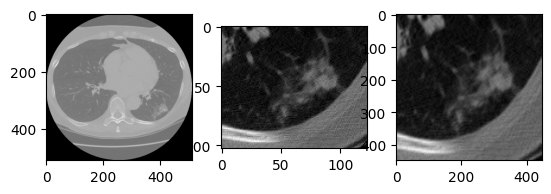

In [ ]:
# Try plotting for one
# index = 0
index = df_for_csv[df_for_csv['width_voxel']==123].index.tolist()[0]
print('index: ' + str(index))
print(df_for_csv.iloc[index])

# Get original image
im = np.array(pydicom.dcmread(dicom_files[index]).pixel_array)

# Get cropped image
min_x = df_for_csv['min_x_voxel'].values[index]
max_x = df_for_csv['max_x_voxel'].values[index]
min_y = df_for_csv['min_y_voxel'].values[index]
max_y = df_for_csv['max_y_voxel'].values[index]
im_crop = im[min_y:max_y, min_x:max_x]

# Get cropped image that is now resized
im_crop_and_resize = np.array(imgs[index])

plt.subplot(1,3,1)
plt.imshow(im, cmap='gray')
plt.subplot(1,3,2)
plt.imshow(im_crop, cmap='gray')
plt.subplot(1,3,3)
plt.imshow(im_crop_and_resize, cmap='gray')
plt.show()

# Obtain Image Embeddings

In [ ]:
# @title Prepare model and inputs

model = SiglipVisionModel.from_pretrained("google/medsiglip-448")
processor = AutoProcessor.from_pretrained("google/medsiglip-448")

inputs = processor(images=imgs, padding="max_length", return_tensors="pt")

In [ ]:
# @title Run model

import time
start_time = time.time()

with torch.no_grad():
    outputs = model(**inputs)

end_time = time.time()
print('Elapsed time to run model: ' + str((end_time-start_time)/60))

Elapsed time to run model: 18.989987126986186


In [ ]:
# @title Normalize outputs to embeddings

# This matches the embeddings produced by the SiglipModel class.
output_embeddings = outputs["pooler_output"] / outputs["pooler_output"].norm(p=2, dim=-1, keepdim=True)

In [ ]:
output_embeddings_np = output_embeddings.numpy()
print(output_embeddings_np.shape)

(525, 1152)


## Save image embeddings

In [ ]:
# save the df_for_csv file

# Save the dataframe so can load and train/val/test later.
df_for_csv.to_csv("/content/medsiglip_info.csv")

In [ ]:
# Temporarily save to drive

!cp "/content/medsiglip_info.csv" "/content/gdrive/MyDrive/Colab Notebooks/SR_NLST_Sybil/demo/"

In [ ]:
df_for_csv.columns

Index(['PatientID', 'SeriesInstanceUID', 'SOPInstanceUID', 'image_path',
       'center_x_voxel', 'center_y_voxel', 'height_voxel', 'width_voxel',
       'min_x_voxel', 'max_x_voxel', 'min_y_voxel', 'max_y_voxel'],
      dtype='object')

In [ ]:
df_sr_and_nlst_subset.columns

Index(['Unnamed: 0', 'PatientID', 'StudyInstanceUID', 'StudyDate', 'study_yr',
       'SeriesInstanceUID', 'ReferencedSeriesInstanceUID',
       'sop_count_per_series', 'TrackingIdentifier', 'TrackingUID',
       'ReferencedSOPInstanceUID', 'FindingType', 'FindingSite',
       'pixel_spacing_x', 'pixel_spacing_y', 'width', 'height', 'center_x',
       'center_y', 'ipp0', 'ipp1', 'ipp2', 'sct_slice_num', 'de_stag_mapped'],
      dtype='object')

In [ ]:
sop_list = df_for_csv['SOPInstanceUID'].values
labels = df_sr_and_nlst_subset[df_sr_and_nlst_subset['ReferencedSOPInstanceUID'].isin(sop_list)]['de_stag_mapped'].values
print(len(sop_list))
print(len(labels))

525
525


In [ ]:
# Create a file similar to the FMCIB one
# PatientID, SeriesInstanceUID, SOPInstanceUID,
# 'center_x_voxel'
# 'center_y_voxel'
# 'height_voxel'
# 'width_voxel'
# 'min_x_voxel'
# 'max_x_voxel'
# 'min_y_voxel'
# 'max_y_voxel'
# then columns for 0 to 1151

df_for_csv2 = df_for_csv.copy(deep=True)

# Add classification label - stage 0/1
df_for_csv2['label'] = labels
# Create column names
col_names = [f"pred_{i}" for i in range(1152)]
# Create a new DataFrame from the output embeddings numpy array
preds_df = pd.DataFrame(output_embeddings_np, columns=col_names)
# Concatenate along columns
df_for_csv2 = pd.concat([df_for_csv2, preds_df], axis=1)

# Save csv
df_for_csv2.to_csv("/content/medsiglip_features.csv")

In [ ]:
# Temporarily save to drive

!cp "/content/medsiglip_features.csv" "/content/gdrive/MyDrive/Colab Notebooks/SR_NLST_Sybil/demo/"

In [ ]:
print(df_for_csv2.shape)

(525, 1165)


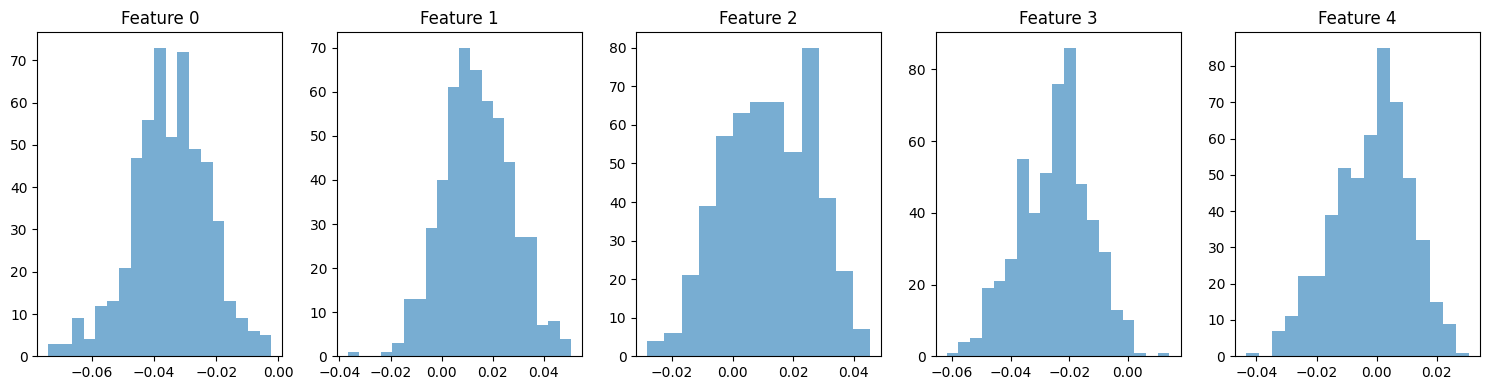

In [ ]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 5, figsize=(15, 4), tight_layout=True)

for i, ax in enumerate(axs):
    ax.hist(df_for_csv2[f"pred_{i}"], bins='auto', alpha=0.6)
    ax.set_title(f'Feature {i}')

plt.show()